<a href="https://colab.research.google.com/github/snigdhaaleti/GenAI/blob/main/Hackathon_GENAI_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q yfinance matplotlib numpy pandas gradio openai langchain langchain-openai


In [ ]:
# === SAFE IMPORTS + CONFIG (works in Colab OR local Python) ===
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# LangChain & OpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

# --- Colab-safe key loading ---
try:
    # Works only if running in Google Colab
    from google.colab import userdata
    openai_key = userdata.get("OPENAI_API_KEY")
except Exception:
    # Fallback for non-Colab environments
    openai_key = os.getenv("OPENAI_API_KEY")

if openai_key:
    os.environ["OPENAI_API_KEY"] = openai_key
    print("✅ OpenAI API Key loaded!")
else:
    print("⚠️ No OpenAI key found. Please set it manually via os.environ or Colab userdata.")

print("✅ Libraries imported successfully!")


✅ OpenAI API Key loaded!
✅ Libraries imported successfully!


In [ ]:
# Cell 4: Global Data Storage
stock_data_storage = {}
print("✅ Global storage initialized!")

✅ Global storage initialized!


In [ ]:
# Cell 5: Tool 1 - Stock Data Downloader
def download_stock_data(query: str) -> str:
    """
    Downloads historical stock data using yfinance.
    Input: 'AAPL,MSFT,GOOGL' or 'TSLA NVDA'
    """
    try:
        tickers = [t.strip().upper() for t in query.replace(',', ' ').split()]
        start_date = datetime.now() - timedelta(days=730)
        end_date = datetime.now()
        results = []

        for ticker in tickers:
            try:
                data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
                if data.empty:
                    results.append(f"❌ {ticker}: No data found")
                    continue

                stock_data_storage[ticker] = data
                latest_price = data['Close'].iloc[-1].item() if hasattr(data['Close'].iloc[-1], 'item') else data['Close'].iloc[-1]
                avg_volume = data['Volume'].mean().item() if hasattr(data['Volume'].mean(), 'item') else data['Volume'].mean()
                results.append(f"✅ {ticker}: {len(data)} days | Latest: ${latest_price:.2f} | Avg Vol: {avg_volume:,.0f}")
            except Exception as e:
                results.append(f"❌ {ticker}: {str(e)}")

        return "\n".join(results) if results else "❌ No data downloaded"
    except Exception as e:
        return f"❌ Error downloading data: {str(e)}"

data_download_tool = Tool(
    name="Stock Data Downloader",
    func=download_stock_data,
    description="Downloads historical stock data. Input: 'AAPL,MSFT,GOOGL' or 'TSLA NVDA'"
)

print("✅ Tool 1: Stock Data Downloader created!")

✅ Tool 1: Stock Data Downloader created!


In [ ]:
# Cell 6: Tool 2 - Technical Analysis Calculator
def calculate_technical_metrics(query: str) -> str:
    """Calculates technical metrics for a stock."""
    try:
        ticker = query.strip().upper()
        if ticker not in stock_data_storage:
            return f"❌ No data for {ticker}. Download first."

        data = stock_data_storage[ticker].copy()
        data['Daily_Return'] = data['Close'].pct_change()

        volatility = float(data['Daily_Return'].std() * np.sqrt(252))
        close_last = float(data['Close'].iloc[-1])
        close_first = float(data['Close'].iloc[0])
        total_return = (close_last / close_first - 1) * 100
        annualized_return = ((1 + total_return/100) ** (252/len(data)) - 1) * 100
        risk_free_rate = 0.02
        excess_return = annualized_return/100 - risk_free_rate
        sharpe_ratio = excess_return / volatility if volatility > 0 else 0
        ma_7 = float(data['Close'].tail(7).mean())
        ma_30 = float(data['Close'].tail(30).mean())

        return f"""📊 Technical Analysis for {ticker}:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 Latest Price: ${close_last:.2f}
📉 Volatility (Annual): {volatility*100:.2f}%
💰 Total Return: {total_return:.2f}%
📊 Annualized Return: {annualized_return:.2f}%
⚖️ Sharpe Ratio: {sharpe_ratio:.3f}
📅 7-Day MA: ${ma_7:.2f}
📅 30-Day MA: ${ma_30:.2f}"""
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 2: Technical Analysis Calculator created!")

✅ Tool 2: Technical Analysis Calculator created!


In [ ]:
# Cell 7: Tool 3 - Market Sentiment Analyzer
def analyze_market_sentiment(query: str) -> str:
    """Analyzes market sentiment using LLM."""
    try:
        ticker = query.strip().upper()
        if ticker not in stock_data_storage:
            return f"❌ No data for {ticker}. Download first."

        data = stock_data_storage[ticker].copy()
        close_last = float(data['Close'].iloc[-1])
        close_30d_ago = float(data['Close'].iloc[-30])
        close_7d_ago = float(data['Close'].iloc[-7])
        price_change_30d = ((close_last / close_30d_ago) - 1) * 100
        price_change_7d = ((close_last / close_7d_ago) - 1) * 100

        data['Daily_Return'] = data['Close'].pct_change()
        volatility = float(data['Daily_Return'].std() * np.sqrt(252))

        ma_7 = float(data['Close'].tail(7).mean())
        ma_30 = float(data['Close'].tail(30).mean())

        if ma_7 > ma_30 and price_change_7d > 0:
            trend = "Bullish"
            trend_emoji = "📈"
        elif ma_7 < ma_30 and price_change_7d < 0:
            trend = "Bearish"
            trend_emoji = "📉"
        else:
            trend = "Neutral"
            trend_emoji = "➡️"

        if volatility < 0.2:
            vol_sentiment = "Low volatility suggests stability"
        elif volatility < 0.35:
            vol_sentiment = "Moderate volatility indicates normal market conditions"
        else:
            vol_sentiment = "High volatility signals increased risk"

        llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0.3)
        prompt = f"""You are a financial sentiment analyst. Analyze {ticker}:

- Current Price: ${close_last:.2f}
- 7-day change: {price_change_7d:.2f}%
- 30-day change: {price_change_30d:.2f}%
- Annual Volatility: {volatility*100:.2f}%
- Trend: {trend}

Provide:
1. Overall Sentiment (Positive/Neutral/Negative)
2. Confidence Level (High/Medium/Low)
3. 2-3 Key Factors
4. Investment Recommendation (Buy/Hold/Sell)

Keep response concise (4-5 sentences)."""

        response = llm.invoke(prompt)

        return f"""💭 Sentiment Analysis for {ticker}:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
{trend_emoji} Current Trend: {trend}
📊 Price Performance:
  • 7-Day Change: {price_change_7d:+.2f}%
  • 30-Day Change: {price_change_30d:+.2f}%

📉 Volatility: {volatility*100:.2f}% - {vol_sentiment}

🤖 AI Market Analysis:
{response.content}"""
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 3: Market Sentiment Analyzer created!")

✅ Tool 3: Market Sentiment Analyzer created!


In [ ]:
# Cell 8: Tool 4 - Portfolio Risk Assessor
def assess_portfolio_risk(query: str) -> str:
    """Assesses portfolio risk based on volatility."""
    try:
        tickers = [t.strip().upper() for t in query.split(',')]
        missing = [t for t in tickers if t not in stock_data_storage]
        if missing:
            return f"❌ Missing data for: {', '.join(missing)}"

        volatilities = {}
        for t in tickers:
            data = stock_data_storage[t]
            daily_returns = data['Close'].pct_change()
            vol = float(daily_returns.std() * np.sqrt(252))
            volatilities[t] = vol

        avg_vol = float(np.mean(list(volatilities.values())))

        if avg_vol < 0.2:
            risk_level = "LOW 🟢"
            recommendation = "Suitable for conservative investors."
        elif avg_vol < 0.35:
            risk_level = "MEDIUM 🟡"
            recommendation = "Balanced investors can consider."
        else:
            risk_level = "HIGH 🔴"
            recommendation = "Only suitable for aggressive investors."

        stock_risks = "\n".join([f"  • {t}: {v*100:.2f}%" for t, v in volatilities.items()])

        return f"""⚖️ Portfolio Risk Assessment:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 Stocks Analyzed: {', '.join(tickers)}

Individual Volatilities:
{stock_risks}

📈 Average Portfolio Volatility: {avg_vol*100:.2f}%
🎯 Risk Level: {risk_level}

💡 Recommendation: {recommendation}"""
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 4: Portfolio Risk Assessor created!")

✅ Tool 4: Portfolio Risk Assessor created!


In [ ]:
# Cell 9: Tool 5 - Portfolio Optimizer
def optimize_portfolio(query: str) -> str:
    """Optimizes portfolio allocation based on risk profile."""
    try:
        parts = query.split()
        if len(parts) < 3:
            return "❌ Format: 'amount risk_profile tickers' (e.g., '10000 moderate AAPL,MSFT,GOOGL')"

        portfolio_amount = float(parts[0].replace('$', '').replace(',', ''))
        risk_profile = parts[1].lower()
        ticker_string = ' '.join(parts[2:])
        tickers = [t.strip().upper() for t in ticker_string.replace(',', ' ').split()]

        missing = [t for t in tickers if t not in stock_data_storage]
        if missing:
            return f"❌ Missing data for: {', '.join(missing)}"

        sharpe_ratios = {}
        for t in tickers:
            data = stock_data_storage[t]
            daily_returns = data['Close'].pct_change()
            volatility = float(daily_returns.std() * np.sqrt(252))
            close_last = float(data['Close'].iloc[-1])
            close_first = float(data['Close'].iloc[0])
            total_return = (close_last / close_first - 1)
            annualized_return = float((1 + total_return) ** (252/len(data)) - 1)

            if volatility > 0:
                sharpe = float((annualized_return - 0.02) / volatility)
            else:
                sharpe = 0.0
            sharpe_ratios[t] = max(sharpe, 0.0)

        if risk_profile == 'conservative':
            weights = {t: 1.0/len(tickers) for t in tickers}
        elif risk_profile == 'moderate':
            total_sharpe = sum(sharpe_ratios.values())
            if total_sharpe > 0:
                weights = {t: (s/total_sharpe*0.7 + 0.3/len(tickers)) for t, s in sharpe_ratios.items()}
            else:
                weights = {t: 1.0/len(tickers) for t in tickers}
        else:
            total_sharpe = sum(sharpe_ratios.values())
            if total_sharpe > 0:
                weights = {t: s/total_sharpe for t, s in sharpe_ratios.items()}
            else:
                weights = {t: 1.0/len(tickers) for t in tickers}

        total_weight = sum(weights.values())
        weights = {t: w/total_weight for t, w in weights.items()}
        allocations = {t: portfolio_amount*w for t, w in weights.items()}

        allocation_details = "\n".join([f"💰 {t}: ${amt:,.2f} ({weights[t]*100:.1f}%) | Sharpe: {sharpe_ratios[t]:.3f}"
                                       for t, amt in allocations.items()])

        llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0.0)
        prompt = f"""Explain this {risk_profile} portfolio for ${portfolio_amount:,.0f}:

{allocation_details}

Focus on diversification and risk justification in 2-3 sentences."""
        reasoning = llm.invoke(prompt).content

        return f"""🎯 Optimized Portfolio for {risk_profile.capitalize()} Investor (${portfolio_amount:,.2f})
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
{allocation_details}

🧠 AI Reasoning:
{reasoning}"""
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 5: Portfolio Optimizer created!")

✅ Tool 5: Portfolio Optimizer created!


In [ ]:

# Cell 10: Tool 6 - Portfolio Visualizer
def visualize_portfolio(query: str) -> str:
    """Creates pie chart for portfolio allocation."""
    try:
        allocations = {t.upper(): float(w) for t, w in (pair.split(':') for pair in query.split(','))}
        plt.figure(figsize=(8,6))
        plt.pie(
            allocations.values(),
            labels=[f"{t}\n{w:.1f}%" for t,w in allocations.items()],
            autopct='%1.1f%%',
            startangle=90
        )
        plt.title("Portfolio Allocation")
        plt.axis('equal')
        plt.show()
        return "✅ Portfolio visualization created!"
    except Exception as e:
        return f"❌ Error: {str(e)}"

visualization_tool = Tool(
    name="Portfolio Visualizer",
    func=visualize_portfolio,
    description="Creates pie chart. Format: 'AAPL:40,MSFT:35,GOOGL:25'"
)

print("✅ Tool 6: Portfolio Visualizer created!")

✅ Tool 6: Portfolio Visualizer created!


In [ ]:
# Cell 11: Tool 7 - Stock Comparison
def compare_stocks(query: str) -> str:
    """Compares multiple stocks on all metrics."""
    try:
        tickers = [t.strip().upper() for t in query.replace(',', ' ').split()]

        if len(tickers) < 2:
            return "❌ Provide at least 2 tickers"

        missing = [t for t in tickers if t not in stock_data_storage]
        if missing:
            return f"❌ Missing data for: {', '.join(missing)}"

        comparison_data = {}

        for ticker in tickers:
            data = stock_data_storage[ticker].copy()
            data['Daily_Return'] = data['Close'].pct_change()

            volatility = float(data['Daily_Return'].std() * np.sqrt(252))
            close_last = float(data['Close'].iloc[-1])
            close_first = float(data['Close'].iloc[0])
            total_return = (close_last / close_first - 1) * 100
            annualized_return = ((1 + total_return/100) ** (252/len(data)) - 1) * 100
            excess_return = annualized_return/100 - 0.02
            sharpe_ratio = excess_return / volatility if volatility > 0 else 0

            close_30d_ago = float(data['Close'].iloc[-30])
            close_7d_ago = float(data['Close'].iloc[-7])
            price_change_30d = ((close_last / close_30d_ago) - 1) * 100
            price_change_7d = ((close_last / close_7d_ago) - 1) * 100

            ma_7 = float(data['Close'].tail(7).mean())
            ma_30 = float(data['Close'].tail(30).mean())

            if ma_7 > ma_30 and price_change_7d > 0:
                trend = "Bullish 📈"
            elif ma_7 < ma_30 and price_change_7d < 0:
                trend = "Bearish 📉"
            else:
                trend = "Neutral ➡️"

            comparison_data[ticker] = {
                'price': close_last,
                'volatility': volatility,
                'sharpe': sharpe_ratio,
                'total_return': total_return,
                'annual_return': annualized_return,
                'price_7d': price_change_7d,
                'price_30d': price_change_30d,
                'trend': trend
            }

        result = "📊 Stock Comparison Analysis\n"
        result += "━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n\n"

        result += "💰 Current Prices:\n"
        for ticker, metrics in comparison_data.items():
            result += f"  • {ticker}: ${metrics['price']:.2f}\n"

        result += "\n📉 Annual Volatility:\n"
        sorted_vol = sorted(comparison_data.items(), key=lambda x: x[1]['volatility'])
        for ticker, metrics in sorted_vol:
            risk_label = "🟢 Low" if metrics['volatility'] < 0.3 else "🟡 Medium" if metrics['volatility'] < 0.5 else "🔴 High"
            result += f"  • {ticker}: {metrics['volatility']*100:.2f}% {risk_label}\n"

        result += "\n⚖️ Sharpe Ratio:\n"
        sorted_sharpe = sorted(comparison_data.items(), key=lambda x: x[1]['sharpe'], reverse=True)
        for ticker, metrics in sorted_sharpe:
            performance = "🏆 Excellent" if metrics['sharpe'] > 1.0 else "✅ Good" if metrics['sharpe'] > 0.5 else "⚠️ Fair"
            result += f"  • {ticker}: {metrics['sharpe']:.3f} {performance}\n"

        result += "\n📈 Returns:\n"
        for ticker, metrics in comparison_data.items():
            result += f"  • {ticker}:\n"
            result += f"    - Total: {metrics['total_return']:+.2f}%\n"
            result += f"    - Annualized: {metrics['annual_return']:+.2f}%\n"
            result += f"    - 7-Day: {metrics['price_7d']:+.2f}%\n"
            result += f"    - 30-Day: {metrics['price_30d']:+.2f}%\n"

        result += "\n🎯 Current Trend:\n"
        for ticker, metrics in comparison_data.items():
            result += f"  • {ticker}: {metrics['trend']}\n"

        result += "\n🏆 Summary:\n"
        best_sharpe = max(comparison_data.items(), key=lambda x: x[1]['sharpe'])
        lowest_vol = min(comparison_data.items(), key=lambda x: x[1]['volatility'])
        best_return = max(comparison_data.items(), key=lambda x: x[1]['total_return'])

        result += f"  • Best Risk-Adjusted Return: {best_sharpe[0]} (Sharpe: {best_sharpe[1]['sharpe']:.3f})\n"
        result += f"  • Lowest Volatility: {lowest_vol[0]} ({lowest_vol[1]['volatility']*100:.2f}%)\n"
        result += f"  • Highest Total Return: {best_return[0]} ({best_return[1]['total_return']:+.2f}%)\n"

        return result
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 7: Stock Comparison created!")

✅ Tool 7: Stock Comparison created!


In [ ]:
# Cell 12: Tool 8 - Multi-Stock Sentiment Analyzer
def analyze_multiple_sentiments(query: str) -> str:
    """Analyzes sentiment for multiple stocks."""
    try:
        tickers = [t.strip().upper() for t in query.replace(',', ' ').split()]

        if len(tickers) < 1:
            return "❌ Provide at least 1 ticker"

        missing = [t for t in tickers if t not in stock_data_storage]
        if missing:
            return f"❌ Missing data for: {', '.join(missing)}"

        sentiments = {}

        for ticker in tickers:
            data = stock_data_storage[ticker].copy()
            close_last = float(data['Close'].iloc[-1])
            close_30d_ago = float(data['Close'].iloc[-30])
            close_7d_ago = float(data['Close'].iloc[-7])
            price_change_30d = ((close_last / close_30d_ago) - 1) * 100
            price_change_7d = ((close_last / close_7d_ago) - 1) * 100

            data['Daily_Return'] = data['Close'].pct_change()
            volatility = float(data['Daily_Return'].std() * np.sqrt(252))

            ma_7 = float(data['Close'].tail(7).mean())
            ma_30 = float(data['Close'].tail(30).mean())

            if ma_7 > ma_30 and price_change_7d > 0:
                trend = "Bullish"
            elif ma_7 < ma_30 and price_change_7d < 0:
                trend = "Bearish"
            else:
                trend = "Neutral"

            sentiments[ticker] = {
                'price': close_last,
                'change_7d': price_change_7d,
                'change_30d': price_change_30d,
                'volatility': volatility,
                'trend': trend
            }

        llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0.3)

        sentiment_summary = "\n".join([
            f"- {ticker}: Price ${data['price']:.2f}, 7d: {data['change_7d']:+.2f}%, 30d: {data['change_30d']:+.2f}%, Vol: {data['volatility']*100:.2f}%, Trend: {data['trend']}"
            for ticker, data in sentiments.items()
        ])

        prompt = f"""You are a financial analyst comparing multiple stocks:

{sentiment_summary}

For each stock provide:
1. Sentiment (Bullish/Neutral/Bearish)
2. Key strengths or concerns
3. Comparative ranking

Keep response concise (6-8 sentences total)."""

        response = llm.invoke(prompt)

        result = "💭 Multi-Stock Sentiment Analysis\n"
        result += "━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n\n"

        for ticker, data in sentiments.items():
            trend_emoji = "📈" if data['trend'] == "Bullish" else "📉" if data['trend'] == "Bearish" else "➡️"
            result += f"{trend_emoji} {ticker}: {data['trend']} Trend\n"
            result += f"  • 7-Day: {data['change_7d']:+.2f}% | 30-Day: {data['change_30d']:+.2f}%\n"
            result += f"  • Volatility: {data['volatility']*100:.2f}%\n\n"

        result += "🤖 AI Comparative Analysis:\n"
        result += response.content

        return result
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 8: Multi-Stock Sentiment Analyzer created!")

✅ Tool 8: Multi-Stock Sentiment Analyzer created!


In [ ]:
# Cell 13: Tool 9 - Price Chart Visualizer
def visualize_price_chart(query: str) -> str:
    """Creates price chart with moving averages."""
    try:
        ticker = query.strip().upper()

        if ticker not in stock_data_storage:
            return f"❌ No data for {ticker}"

        data = stock_data_storage[ticker].copy()
        data['MA7'] = data['Close'].rolling(window=7).mean()
        data['MA30'] = data['Close'].rolling(window=30).mean()
        data['MA90'] = data['Close'].rolling(window=90).mean()

        plt.figure(figsize=(14, 8))
        plt.plot(data.index, data['Close'], label='Close Price', linewidth=2, color='#1f77b4')
        plt.plot(data.index, data['MA7'], label='7-Day MA', linewidth=1.5, alpha=0.7, color='#ff7f0e')
        plt.plot(data.index, data['MA30'], label='30-Day MA', linewidth=1.5, alpha=0.7, color='#2ca02c')
        plt.plot(data.index, data['MA90'], label='90-Day MA', linewidth=1.5, alpha=0.7, color='#d62728')

        plt.title(f'{ticker} Price Chart with Moving Averages', fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend(loc='best', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        latest_price = float(data['Close'].iloc[-1])
        price_change = ((latest_price / float(data['Close'].iloc[0])) - 1) * 100

        return f"""✅ Price chart created for {ticker}!

📊 Chart Summary:
  • Latest Price: ${latest_price:.2f}
  • Total Return: {price_change:+.2f}%
  • 7-Day MA: ${float(data['MA7'].iloc[-1]):.2f}
  • 30-Day MA: ${float(data['MA30'].iloc[-1]):.2f}
  • 90-Day MA: ${float(data['MA90'].iloc[-1]):.2f}"""
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 9: Price Chart Visualizer created!")

✅ Tool 9: Price Chart Visualizer created!


In [ ]:
# Cell 14: Tool 10 - Volume Chart Visualizer
def visualize_volume_chart(query: str) -> str:
    """Creates price and volume chart."""
    try:
        ticker = query.strip().upper()

        if ticker not in stock_data_storage:
            return f"❌ No data for {ticker}"

        data = stock_data_storage[ticker].copy()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                        gridspec_kw={'height_ratios': [3, 1]})

        ax1.plot(data.index, data['Close'], label='Close Price', linewidth=2, color='#1f77b4')
        ax1.plot(data.index, data['Close'].rolling(7).mean(), label='7-Day MA',
                linewidth=1.5, alpha=0.7, color='#ff7f0e')
        ax1.plot(data.index, data['Close'].rolling(30).mean(), label='30-Day MA',
                linewidth=1.5, alpha=0.7, color='#2ca02c')

        ax1.set_title(f'{ticker} Price and Volume Chart', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.legend(loc='best', fontsize=10)
        ax1.grid(True, alpha=0.3)

        colors = ['g' if data['Close'].iloc[i] >= data['Close'].iloc[i-1] else 'r'
                 for i in range(1, len(data))]
        colors.insert(0, 'g')

        ax2.bar(data.index, data['Volume'], color=colors, alpha=0.6)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Volume', fontsize=12)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        latest_price = float(data['Close'].iloc[-1])
        avg_volume = float(data['Volume'].mean())

        return f"""✅ Price and volume chart created for {ticker}!

📊 Chart Includes:
  • Price trend with 7-day and 30-day moving averages
  • Volume bars (green = price up, red = price down)

📈 Current Stats:
  • Latest Price: ${latest_price:.2f}
  • Average Daily Volume: {avg_volume:,.0f}"""
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 10: Volume Chart Visualizer created!")

✅ Tool 10: Volume Chart Visualizer created!


In [ ]:
# Cell 15: Tool 11 - Multi-Stock Comparison Chart
def visualize_comparison_chart(query: str) -> str:
    """Creates normalized comparison chart for multiple stocks."""
    try:
        tickers = [t.strip().upper() for t in query.replace(',', ' ').split()]

        if len(tickers) < 2:
            return "❌ Provide at least 2 tickers"

        missing = [t for t in tickers if t not in stock_data_storage]
        if missing:
            return f"❌ Missing data for: {', '.join(missing)}"

        plt.figure(figsize=(14, 8))

        for ticker in tickers:
            data = stock_data_storage[ticker].copy()
            normalized = (data['Close'] / data['Close'].iloc[0] - 1) * 100
            plt.plot(data.index, normalized, label=ticker, linewidth=2)

        plt.title('Stock Price Comparison (Normalized %)', fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Return (%)', fontsize=12)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        results = []
        for ticker in tickers:
            data = stock_data_storage[ticker]
            total_return = ((float(data['Close'].iloc[-1]) / float(data['Close'].iloc[0])) - 1) * 100
            results.append(f"  • {ticker}: {total_return:+.2f}%")

        return f"""✅ Comparison chart created for {', '.join(tickers)}!

📊 Total Returns:
{chr(10).join(results)}"""
    except Exception as e:
        return f"❌ Error: {str(e)}"

print("✅ Tool 11: Multi-Stock Comparison Chart created!")

✅ Tool 11: Multi-Stock Comparison Chart created!


In [ ]:
# Cell 16: Smart Wrappers
def smart_technical_analysis(query: str) -> str:
    ticker = query.strip().upper()
    if ticker not in stock_data_storage:
        print(f"📥 Auto-downloading data for {ticker}...")
        download_result = download_stock_data(ticker)
        if "❌" in download_result:
            return download_result
    return calculate_technical_metrics(query)

def smart_sentiment_analysis(query: str) -> str:
    ticker = query.strip().upper()
    if ticker not in stock_data_storage:
        print(f"📥 Auto-downloading data for {ticker}...")
        download_result = download_stock_data(ticker)
        if "❌" in download_result:
            return download_result
    return analyze_market_sentiment(query)

def smart_stock_comparison(query: str) -> str:
    tickers = [t.strip().upper() for t in query.replace(',', ' ').split()]
    missing = [t for t in tickers if t not in stock_data_storage]
    if missing:
        print(f"📥 Auto-downloading data for {', '.join(missing)}...")
        download_result = download_stock_data(','.join(missing))
        if "❌" in download_result:
            return download_result
    return compare_stocks(query)

def smart_multi_sentiment(query: str) -> str:
    tickers = [t.strip().upper() for t in query.replace(',', ' ').split()]
    missing = [t for t in tickers if t not in stock_data_storage]
    if missing:
        print(f"📥 Auto-downloading data for {', '.join(missing)}...")
        download_result = download_stock_data(','.join(missing))
        if "❌" in download_result:
            return download_result
    return analyze_multiple_sentiments(query)

def smart_risk_assessment(query: str) -> str:
    tickers = [t.strip().upper() for t in query.split(',')]
    missing = [t for t in tickers if t not in stock_data_storage]
    if missing:
        print(f"📥 Auto-downloading data for {', '.join(missing)}...")
        download_result = download_stock_data(','.join(missing))
        if "❌" in download_result:
            return download_result
    return assess_portfolio_risk(query)

def smart_portfolio_optimizer(query: str) -> str:
    try:
        parts = query.split()
        if len(parts) < 3:
            return "❌ Format: 'amount risk_profile tickers'"
        ticker_string = ' '.join(parts[2:])
        tickers = [t.strip().upper() for t in ticker_string.replace(',', ' ').split()]
        missing = [t for t in tickers if t not in stock_data_storage]
        if missing:
            print(f"📥 Auto-downloading data for {', '.join(missing)}...")
            download_result = download_stock_data(','.join(missing))
            if "❌" in download_result:
                return download_result
        return optimize_portfolio(query)
    except Exception as e:
        return f"❌ Error: {str(e)}"

def smart_price_chart(query: str) -> str:
    ticker = query.strip().upper()
    if ticker not in stock_data_storage:
        print(f"📥 Auto-downloading data for {ticker}...")
        download_result = download_stock_data(ticker)
        if "❌" in download_result:
            return download_result
    return visualize_price_chart(query)

def smart_volume_chart(query: str) -> str:
    ticker = query.strip().upper()
    if ticker not in stock_data_storage:
        print(f"📥 Auto-downloading data for {ticker}...")
        download_result = download_stock_data(ticker)
        if "❌" in download_result:
            return download_result
    return visualize_volume_chart(query)

def smart_comparison_chart(query: str) -> str:
    tickers = [t.strip().upper() for t in query.replace(',', ' ').split()]
    missing = [t for t in tickers if t not in stock_data_storage]
    if missing:
        print(f"📥 Auto-downloading data for {', '.join(missing)}...")
        download_result = download_stock_data(','.join(missing))
        if "❌" in download_result:
            return download_result
    return visualize_comparison_chart(query)

print("✅ Smart wrappers created!")

✅ Smart wrappers created!


In [ ]:
# Cell 17: Initialize Memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="output"
)

print("✅ Memory initialized!")

✅ Memory initialized!


/tmp/ipython-input-2714002725.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


In [ ]:
# Cell 18: Initialize Agent with All Tools
tools = [
    data_download_tool,
    Tool(
        name="Technical Analysis Calculator",
        func=smart_technical_analysis,
        description="Calculates volatility, Sharpe ratio, returns, moving averages. Input: ticker (e.g., 'AAPL')"
    ),
    Tool(
        name="Sentiment Analyzer",
        func=smart_sentiment_analysis,
        description="Analyzes market sentiment. Input: ticker (e.g., 'NVDA')"
    ),
    Tool(
        name="Risk Assessor",
        func=smart_risk_assessment,
        description="Assesses portfolio risk. Input: 'AAPL,MSFT,GOOGL'"
    ),
    Tool(
        name="Portfolio Optimizer",
        func=smart_portfolio_optimizer,
        description="Optimizes allocation. Input: 'amount risk_profile tickers' (e.g., '10000 moderate AAPL,MSFT,GOOGL')"
    ),
    visualization_tool,
    Tool(
        name="Stock Comparison",
        func=smart_stock_comparison,
        description="Compares multiple stocks. Input: 'TSLA,NVDA' or 'AAPL MSFT GOOGL'"
    ),
    Tool(
        name="Multi-Stock Sentiment",
        func=smart_multi_sentiment,
        description="Analyzes sentiment for multiple stocks. Input: 'TSLA,NVDA'"
    ),
    Tool(
        name="Price Chart Visualizer",
        func=smart_price_chart,
        description="Creates price chart with MAs for SINGLE stock. Input: single ticker (e.g., 'TSLA')"
    ),
    Tool(
        name="Volume Chart Visualizer",
        func=smart_volume_chart,
        description="Creates price and volume chart for SINGLE stock. Input: ticker (e.g., 'TSLA')"
    ),
    Tool(
        name="Comparison Chart Visualizer",
        func=smart_comparison_chart,
        description="Creates normalized comparison for MULTIPLE stocks. Input: 'TSLA,NVDA' or 'AAPL MSFT GOOGL'"
    )
]

llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

system_message = """You are RebalanceAI, a proactive portfolio analysis assistant.

IMPORTANT - Chart Tool Selection:
- ONE stock → use "Price Chart Visualizer"
- MULTIPLE stocks → use "Comparison Chart Visualizer"

All tools automatically download data. Never mention downloading to user."""

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
    max_iterations=20,
    handle_parsing_errors=True,
    agent_kwargs={"system_message": system_message}
)

print("✅ RebalanceAI Agent initialized with all tools!")

✅ RebalanceAI Agent initialized with all tools!


/tmp/ipython-input-3876172927.py:62: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [ ]:
# Cell 19: Interactive Chat Function
def chat_with_agent():
    print("\n" + "="*70)
    print("🤖 Welcome to RebalanceAI - Your Portfolio Analysis Assistant!")
    print("="*70)
    print("\nI can help you with:")
    print("  📊 Portfolio optimization and analysis")
    print("  📈 Technical analysis of stocks")
    print("  💭 Market sentiment analysis")
    print("  ⚖️  Risk assessment")
    print("  📉 Stock data visualization")
    print("\nType 'exit', 'quit', or 'bye' to end the conversation.")
    print("="*70 + "\n")

    conversation_count = 0

    while True:
        try:
            user_input = input("\n💬 You: ").strip()

            if user_input.lower() in ['exit', 'quit', 'bye', 'stop']:
                print("\n" + "="*70)
                print("👋 Thank you for using RebalanceAI! Goodbye!")
                print("="*70)

                if conversation_count > 0:
                    print(f"\n📊 Session Summary:")
                    print(f"   Total interactions: {conversation_count}")
                    print(f"   Stocks analyzed: {', '.join(stock_data_storage.keys()) if stock_data_storage else 'None'}")
                break

            if not user_input:
                print("⚠️  Please enter a question or command.")
                continue

            print("\n🤔 Thinking...\n")
            response = agent.invoke({"input": user_input})

            print("\n" + "="*70)
            print("🤖 RebalanceAI:")
            print("="*70)
            print(response['output'])
            print("="*70)

            conversation_count += 1

        except KeyboardInterrupt:
            print("\n\n⚠️  Interrupted by user.")
            print("👋 Goodbye!")
            break
        except Exception as e:
            print(f"\n❌ Error: {str(e)}")
            print("Please try rephrasing your question or check your input format.\n")

print("✅ Interactive chat function ready!")

✅ Interactive chat function ready!



🤖 Welcome to RebalanceAI - Your Portfolio Analysis Assistant!

I can help you with:
  📊 Portfolio optimization and analysis
  📈 Technical analysis of stocks
  💭 Market sentiment analysis
  ⚖️  Risk assessment
  📉 Stock data visualization

Type 'exit', 'quit', or 'bye' to end the conversation.


💬 You: stock trend for nvda

🤔 Thinking...



> Entering new AgentExecutor chain...
```json
{
    "action": "Price Chart Visualizer",
    "action_input": "NVDA"
}
```📥 Auto-downloading data for NVDA...


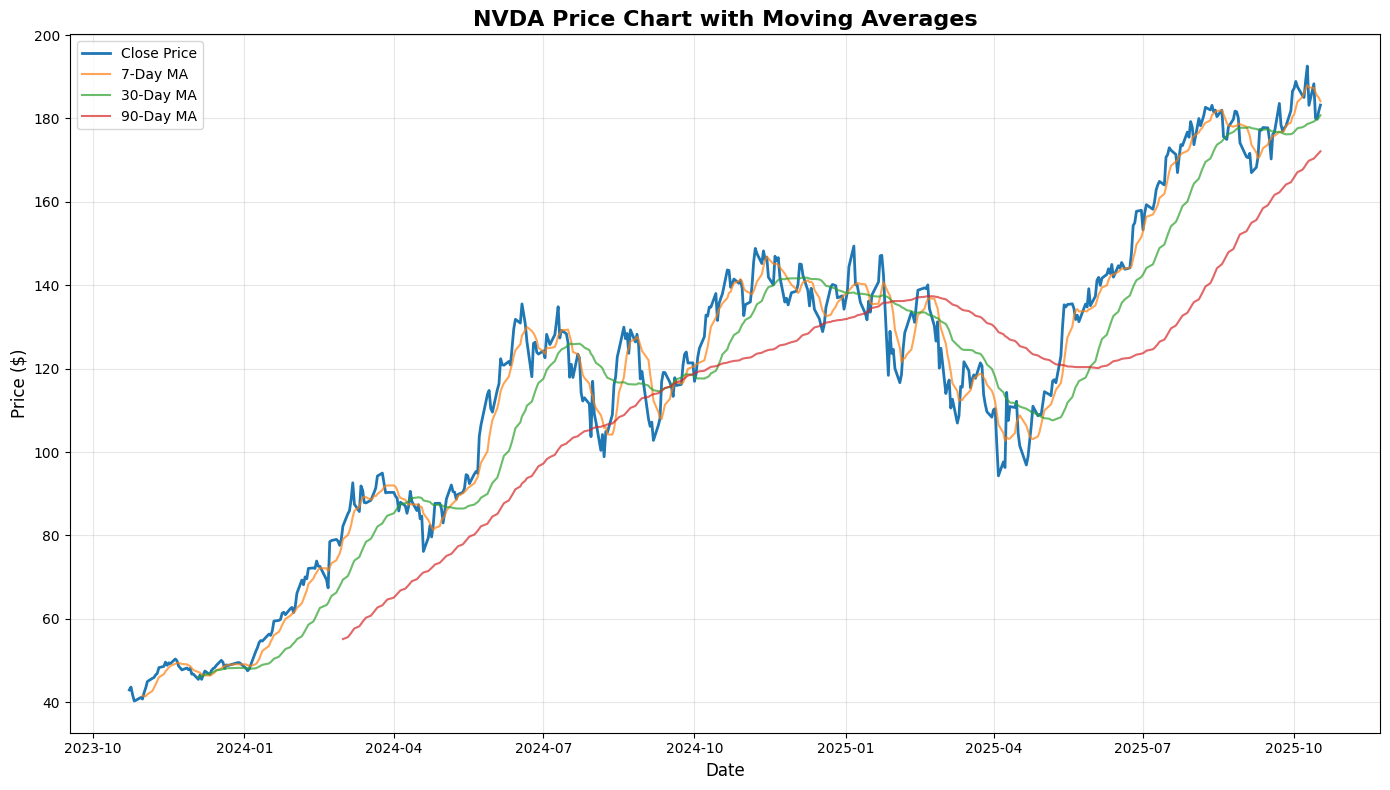

/tmp/ipython-input-3753984006.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(data['Close'].iloc[-1])
/tmp/ipython-input-3753984006.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_change = ((latest_price / float(data['Close'].iloc[0])) - 1) * 100



Observation: ✅ Price chart created for NVDA!

📊 Chart Summary:
  • Latest Price: $183.22
  • Total Return: +326.59%
  • 7-Day MA: $184.13
  • 30-Day MA: $180.76
  • 90-Day MA: $172.14
Thought:```json
{
    "action": "Final Answer",
    "action_input": "The latest price for NVDA is $183.22. It has experienced a total return of +326.59%. The 7-day moving average is $184.13, the 30-day moving average is $180.76, and the 90-day moving average is $172.14."
}
```

> Finished chain.

🤖 RebalanceAI:
The latest price for NVDA is $183.22. It has experienced a total return of +326.59%. The 7-day moving average is $184.13, the 30-day moving average is $180.76, and the 90-day moving average is $172.14.


⚠️  Interrupted by user.
👋 Goodbye!


In [ ]:
# Cell 20: Start Interactive Session
if __name__ == "__main__":
    chat_with_agent()

In [ ]:
# ==========================
# RebalanceAI — Complete Gradio UI with LLM-Powered Ticker Resolution
# ==========================
# Works with your existing functions:
# download_stock_data, stock_data_storage, smart_technical_analysis,
# smart_sentiment_analysis, smart_risk_assessment, smart_portfolio_optimizer, agent
# -----------------------------------------------------

!pip -q install --upgrade websockets==13.1 yfinance==0.2.66 gradio==4.44.0 httpx requests

import re, io, math, base64
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
from difflib import get_close_matches
from langchain_openai import ChatOpenAI

# ---------- Initialize LLM for ticker resolution ----------
llm_resolver = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# ---------- Ensure dependencies exist ----------
def _require(name):
    if name not in globals():
        raise RuntimeError(f"Missing global '{name}'. Define it before running the UI.")
for _sym in [
    "download_stock_data",
    "stock_data_storage",
    "smart_technical_analysis",
    "smart_sentiment_analysis",
    "smart_risk_assessment",
    "smart_portfolio_optimizer",
    "agent",
]:
    _require(_sym)

# ---------- Ticker normalization ----------
_ALIAS = {
    "nvidia": "NVDA", "nvdia": "NVDA",
    "apple": "AAPL", "microsoft": "MSFT",
    "google": "GOOGL", "alphabet": "GOOGL",
    "amazon": "AMZN", "meta": "META", "facebook": "META",
    "tesla": "TSLA"
}
_KNOWN_TICKERS = {
    "AAPL","MSFT","NVDA","GOOGL","AMZN","TSLA","META","NFLX","AMD","IBM","ORCL","INTC","DIS","KO","PEP"
}

def _llm_resolve_ticker(company_name):
    """Use LLM to convert company name to ticker symbol"""
    prompt = f"""Convert this company name to its stock ticker symbol.
    Return ONLY the ticker symbol in uppercase, nothing else.
    If it's already a ticker symbol, return it as-is.
    If unknown, not a public company, or invalid, return 'UNKNOWN'.

    Examples:
    - JPMorgan Chase → JPM
    - Coca Cola → KO
    - Bank of America → BAC
    - Walmart → WMT
    - AAPL → AAPL

    Company/Ticker: {company_name}

    Ticker:"""

    try:
        response = llm_resolver.invoke(prompt)
        ticker = response.content.strip().upper()
        # Validate it's a reasonable ticker (1-5 chars, letters only)
        if ticker != "UNKNOWN" and 1 <= len(ticker) <= 5 and ticker.isalpha():
            return ticker
        return None
    except Exception as e:
        print(f"LLM resolution error: {e}")
        return None

def _normalize_ticker(s):
    if not s: return ""
    s_clean = s.strip().lower()

    # Check aliases first
    if s_clean in _ALIAS:
        return _ALIAS[s_clean]

    s_up = s.strip().upper()

    # Check known tickers
    if s_up in _KNOWN_TICKERS:
        return s_up

    # Try fuzzy matching
    m = get_close_matches(s_up, list(_KNOWN_TICKERS | set(_ALIAS.values())), n=1, cutoff=0.8)
    if m:
        return m[0]

    # NEW: If it looks like a company name (not already a ticker format), ask LLM
    # Indicators: length > 5, contains space, contains non-alpha characters (except for ticker-like format)
    looks_like_name = (
        len(s) > 5 or
        ' ' in s or
        (not s.replace('-', '').replace('.', '').isalnum())
    )

    if looks_like_name:
        llm_result = _llm_resolve_ticker(s)
        if llm_result:
            print(f"✓ Resolved '{s}' → {llm_result}")
            return llm_result

    # Fall back to original uppercase
    return s_up

def _ensure_list(txt):
    return [t.strip() for t in re.split(r"[,\s]+", txt or "") if t.strip()]

def _normalize_many(txt):
    """Normalize multiple tickers/company names"""
    raw_items = _ensure_list(txt)

    # Check if this looks like a natural language list
    # e.g., "Apple and Microsoft" or "JPMorgan, Bank of America"
    if ' and ' in txt.lower() or ',' in txt:
        # Try to use LLM to extract all company names first
        extracted = _extract_companies_from_text(txt)
        if extracted:
            return [_normalize_ticker(t) for t in extracted]

    return [_normalize_ticker(t) for t in raw_items]

def _extract_companies_from_text(text):
    """Use LLM to extract company names or tickers from natural language"""
    prompt = f"""Extract all company names or stock ticker symbols from this text.
    Return them as a comma-separated list of ticker symbols ONLY.

    Examples:
    - "compare Apple and Microsoft" → AAPL,MSFT
    - "show JPMorgan, Bank of America and Wells Fargo" → JPM,BAC,WFC
    - "NVDA vs AMD" → NVDA,AMD

    Text: {text}

    Tickers:"""

    try:
        response = llm_resolver.invoke(prompt)
        result = response.content.strip().upper()
        if result and result != "NONE":
            return [t.strip() for t in result.split(',') if t.strip()]
        return None
    except Exception as e:
        print(f"Company extraction error: {e}")
        return None

# ---------- Data fetching ----------
def _ensure_data_for(tickers):
    missing = [t for t in tickers if t not in stock_data_storage]
    if missing:
        download_stock_data(",".join(missing))
    return [t for t in tickers if t in stock_data_storage]

# ---------- Chat chart helpers ----------
_CHART_KEYWORDS = {"chart","plot","graph","trend","compare","visualize","show chart","show graph"}

def _fig_to_data_uri(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=160, bbox_inches="tight")
    buf.seek(0)
    uri = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return f"data:image/png;base64,{uri}"

def _extract_tickers_from_text(text):
    """Enhanced extraction that handles both tickers and company names"""
    # First try LLM extraction for natural language
    llm_extracted = _extract_companies_from_text(text)
    if llm_extracted:
        return llm_extracted

    # Fallback to regex extraction
    raw = [t for t in re.split(r"[^A-Za-z0-9]+", text or "") if t]
    cands = [t for t in raw if 2 <= len(t) <= 12]
    out = []
    for t in cands:
        n = _normalize_ticker(t)
        if n and n not in out:
            out.append(n)
    return out

# ---------- Chart functions ----------
def ui_price_chart(ticker):
    t = _normalize_ticker(ticker)
    if not t: return None, "❌ Enter a ticker or company name (e.g., AAPL or Apple)."
    _ensure_data_for([t])
    if t not in stock_data_storage: return None, f"❌ No data for {t}."
    df = stock_data_storage[t].copy()
    for w in (7,30,90): df[f"MA{w}"] = df["Close"].rolling(w).mean()
    fig = plt.figure(figsize=(12,6))
    plt.plot(df.index, df["Close"], label="Close", lw=2)
    for w in (7,30,90):
        if not df[f"MA{w}"].isna().all(): plt.plot(df.index, df[f"MA{w}"], label=f"MA{w}", lw=1.5)
    plt.title(f"{t} — Price with Moving Averages"); plt.xlabel("Date"); plt.ylabel("Price ($)")
    plt.legend(); plt.grid(alpha=0.3)
    latest, start = float(df["Close"].iloc[-1]), float(df["Close"].iloc[0])
    ret = (latest/start - 1)*100
    msg = f"✅ **{t}**\n- Latest: ${latest:.2f}\n- Total Return: {ret:+.2f}%"
    return fig, msg

def ui_compare_chart(tickers_str):
    tickers = _normalize_many(tickers_str)
    if len(tickers)<2: return None, "❌ Enter 2+ tickers or company names."
    tickers = _ensure_data_for(tickers)
    if len(tickers)<2: return None, "❌ Could not find data for enough valid tickers."
    fig = plt.figure(figsize=(12,6)); summary=[]
    for t in tickers:
        df = stock_data_storage[t]; base=float(df["Close"].iloc[0]);
        norm=(df["Close"]/base-1)*100; plt.plot(df.index,norm,label=t,lw=2)
        summary.append(f"- **{t}**: {(float(df['Close'].iloc[-1])/base-1)*100:+.2f}%")
    plt.title("Normalized Return Comparison (%)"); plt.legend(); plt.grid(alpha=0.3)
    return fig,"✅ Comparison\n\n"+"\n".join(summary)

def ui_technicals(t): return smart_technical_analysis(_normalize_ticker(t))
def ui_sentiment(t): return smart_sentiment_analysis(_normalize_ticker(t))
def ui_risk(t): return smart_risk_assessment(",".join(_normalize_many(t)))
def ui_optimize(amt,prof,t): return smart_portfolio_optimizer(f"{amt} {prof.lower()} "+",".join(_normalize_many(t)))

# ---------- Chat with chart generation and memory integration ----------
def chat_fn(msg, hist):
    try:
        # First, update agent's memory with conversation history
        # Gradio history format: list of {"role": "user"/"assistant", "content": "..."}
        if hasattr(agent, 'memory') and agent.memory:
            # Clear existing memory to avoid duplication
            agent.memory.clear()

            # Add conversation history to agent's memory
            for turn in hist:
                if turn["role"] == "user":
                    agent.memory.chat_memory.add_user_message(turn["content"])
                elif turn["role"] == "assistant":
                    agent.memory.chat_memory.add_ai_message(turn["content"])

        text = msg.lower(); wants_chart=any(k in text for k in _CHART_KEYWORDS)
        tickers=_extract_tickers_from_text(msg)

        if wants_chart and tickers:
            if len(tickers)==1:
                t=tickers[0]; _ensure_data_for([t])
                if t not in stock_data_storage:
                    return f"❌ Could not fetch data for {t}. Please check the ticker/company name."
                df=stock_data_storage[t]
                for w in (7,30,90): df[f"MA{w}"]=df["Close"].rolling(w).mean()
                fig=plt.figure(figsize=(12,6))
                plt.plot(df.index,df["Close"],label="Close",lw=2)
                for w in (7,30,90):
                    if not df[f"MA{w}"].isna().all(): plt.plot(df.index,df[f"MA{w}"],label=f"MA{w}",lw=1.5)
                plt.title(f"{t} — Price with Moving Averages"); plt.legend(); plt.grid(alpha=0.3)
                uri=_fig_to_data_uri(fig)
                return f"### {t} Chart\n![{t}]({uri})"
            else:
                valids=_ensure_data_for(tickers)
                if len(valids) < 2:
                    return "❌ Could not find data for enough tickers. Please check company names."
                fig=plt.figure(figsize=(12,6))
                for t in valids:
                    df=stock_data_storage[t]; base=float(df["Close"].iloc[0])
                    norm=(df["Close"]/base-1)*100; plt.plot(df.index,norm,label=t,lw=2)
                plt.title("Comparison Chart"); plt.legend(); plt.grid(alpha=0.3)
                uri=_fig_to_data_uri(fig)
                return f"### Comparison Chart ({', '.join(valids)})\n![Compare]({uri})"

        out=agent.invoke({"input":msg})
        return out.get("output","⚠️ No output.")
    except Exception as e:
        return f"❌ Error: {e}"

# ---------- Gradio UI ----------
with gr.Blocks(title="RebalanceAI") as demo:
    gr.Markdown("# 💹 RebalanceAI — Your AI Investment Co-Pilot")
    gr.Markdown("**Now supports company names!** Try: *'plot Apple'*, *'compare Microsoft and Google'*, *'show JPMorgan chart'*")

    with gr.Tab("Chat"):
        gr.ChatInterface(fn=chat_fn, type="messages",
                         examples=[
                             "plot NVDA",
                             "compare Apple and Microsoft",
                             "show chart for JPMorgan Chase",
                             "graph Coca Cola vs Pepsi"
                         ],
                         concurrency_limit=1)

    with gr.Tab("Single Stock Chart"):
        t=gr.Textbox(label="Ticker or Company Name", placeholder="e.g., AAPL or Apple")
        plot=gr.Plot(); out=gr.Markdown()
        gr.Button("Create Chart").click(ui_price_chart,inputs=t,outputs=[plot,out])

    with gr.Tab("Compare Stocks"):
        t2=gr.Textbox(label="Tickers or Company Names", placeholder="e.g., Apple, Microsoft, Google")
        plot2=gr.Plot(); out2=gr.Markdown()
        gr.Button("Compare").click(ui_compare_chart,inputs=t2,outputs=[plot2,out2])

    with gr.Tab("Analytics"):
        t3=gr.Textbox(label="Ticker/Company for Technicals"); tech_out=gr.Markdown()
        gr.Button("Run Technicals").click(ui_technicals,inputs=t3,outputs=tech_out)

        t4=gr.Textbox(label="Ticker/Company for Sentiment"); sent_out=gr.Markdown()
        gr.Button("Run Sentiment").click(ui_sentiment,inputs=t4,outputs=sent_out)

        t5=gr.Textbox(label="Tickers/Companies for Risk"); risk_out=gr.Markdown()
        gr.Button("Assess Risk").click(ui_risk,inputs=t5,outputs=risk_out)

        amt=gr.Textbox(label="Amount ($)"); prof=gr.Dropdown(["conservative","moderate","aggressive"],label="Profile")
        tick=gr.Textbox(label="Tickers/Companies"); opt_out=gr.Markdown()
        gr.Button("Optimize Portfolio").click(ui_optimize,inputs=[amt,prof,tick],outputs=opt_out)

# Lightweight queue; set global worker pool in launch()
demo.queue(max_size=32)
demo.launch(share=True, debug=True, max_threads=8)

ERROR: Cannot install gradio, websockets==13.1 and yfinance==0.2.66 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://79ebfcf55652e71be1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-2402182299.py:265: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df=stock_data_storage[t]; base=float(df["Close"].iloc[0])
/tmp/ipython-input-2402182299.py:215: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df = stock_data_storage[t]; base=float(df["Close"].iloc[0]);
/tmp/ipython-input-2402182299.py:217: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  summary.append(f"- **{t}**: {(float(df['Close'].iloc[-1])/base-1)*100:+.2f}%")
/tmp/ipython-input-2360048882.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_last = float(data['Close'].iloc[-1])
/tmp/ipython-input-236004888

📥 Auto-downloading data for MSFT...


/tmp/ipython-input-1594521898.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility = float(daily_returns.std() * np.sqrt(252))
/tmp/ipython-input-1594521898.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_last = float(data['Close'].iloc[-1])
/tmp/ipython-input-1594521898.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_first = float(data['Close'].iloc[0])
